In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Import packages

from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [3]:
# Import train and test data

train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Exploring data

In [4]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# What are our categorical and non categorical columns

print('Catergorical columns \n')
print(train_df.dtypes[train_df.dtypes == 'object'])

print('\n Numerical columns \n')
print(train_df.dtypes[train_df.dtypes != 'object'])



Catergorical columns 

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      

For numerical features, lets plot correlation between them and SalePrice to look at trends abnd identify outliers to drop

In [7]:
numerical_features = train_df.dtypes[train_df.dtypes != 'object'].drop(['Id','SalePrice'])
print("Number of numerical features: ", len(numerical_features))

Number of numerical features:  36


# Numerical features vs Sale Price

KeyboardInterrupt: 

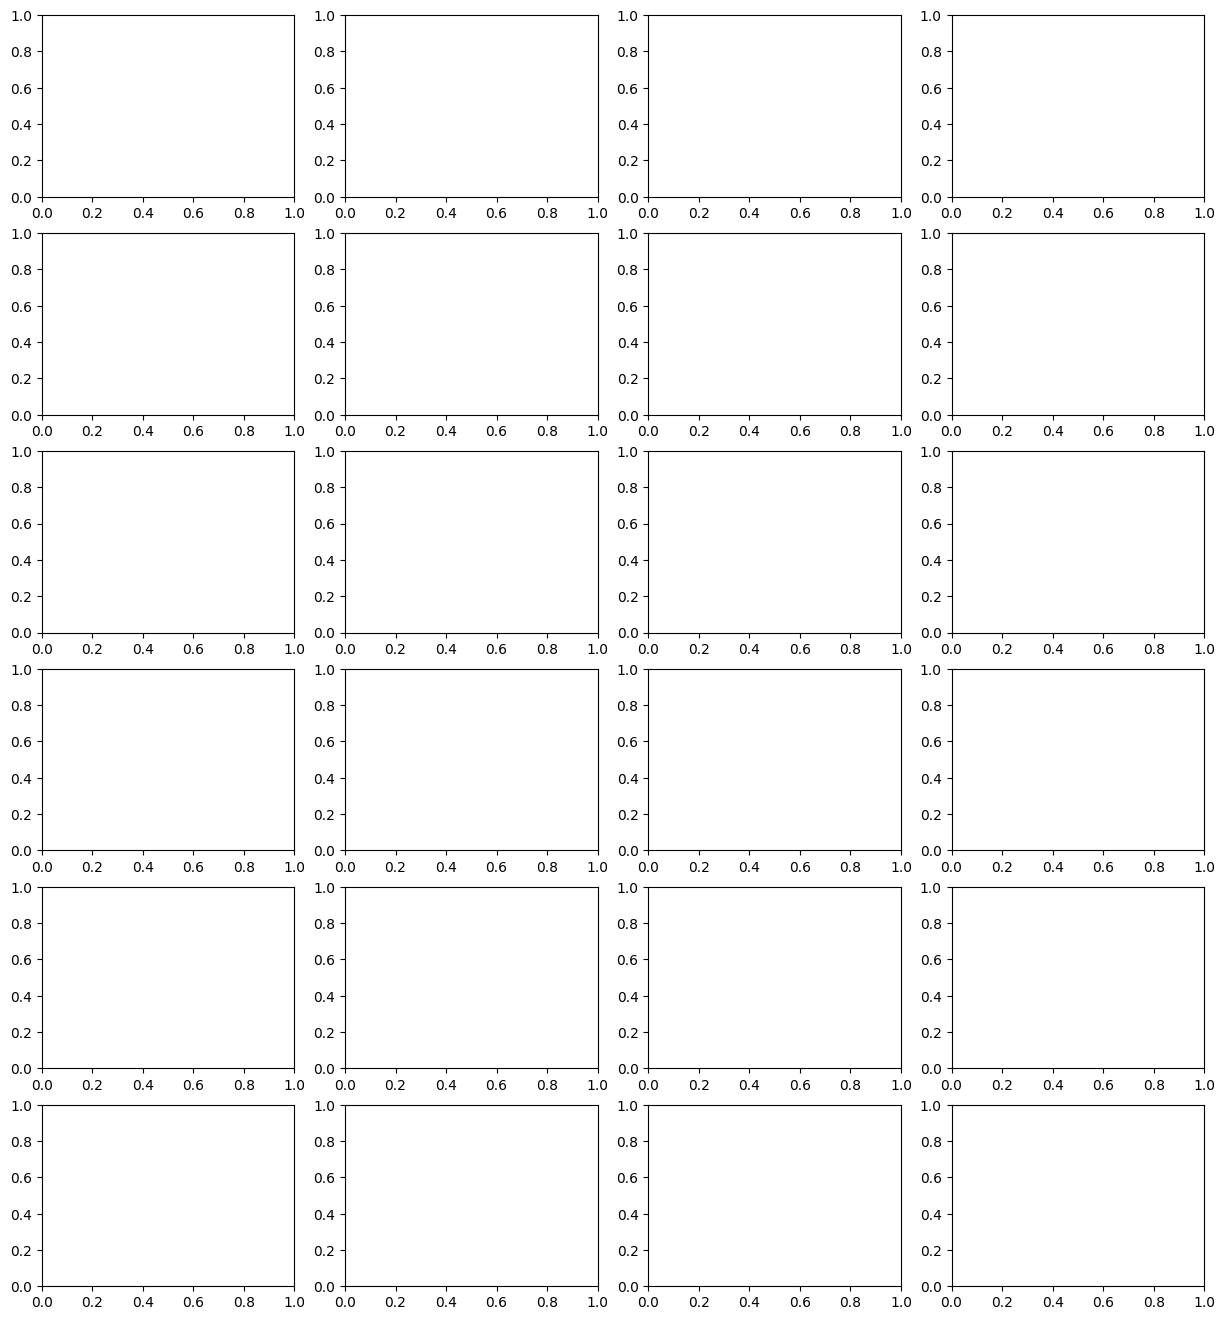

In [8]:
fig, axs = plt.subplots(9,4, figsize=(15,25))
plt.tight_layout()
for i in range(len(numerical_features)):
    axs[i//4,i%4].scatter(train_df[numerical_features.index[i]], train_df['SalePrice'])
    axs[i//4,i%4].set(xlabel=numerical_features.index[i])
plt.suptitle("Numerical Variables vs Sale Price", size=16)
fig.subplots_adjust(top=0.95)
plt.show()

# Removing outliers

We have visible outliers in a number of categories. Before removing them, let's also quantify how much of an outlier they are looking at their z-score

In [ ]:
# Create array of ids we will remove from the dataset

ids = []

In [ ]:
# Starting with Lot Frontage
# We can see our two values on the right of the graph have a zscore of 10, so big outliers

stats.zscore(train_df['LotFrontage'].dropna()).sort_values().tail(10)

In [ ]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['LotFrontage'].dropna())
z_outliers = z[stats.zscore(train_df['LotFrontage'].dropna()) > 5]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# Lets look at Lot Area
# Let's drop those where the zscore >10

stats.zscore(train_df['LotArea'].dropna()).sort_values().tail(10)

In [ ]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['LotArea'].dropna())
z_outliers = z[stats.zscore(train_df['LotArea'].dropna()) > 10]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# It looks like we have some outliers for where OverallCond = 2, 5 6, let's check those
# The z-score for the large value for where OverallCond=2 isn't that crazy, but that's because there are a small number of values. From the eye test it looks bad

print(stats.zscore(train_df[train_df['OverallCond'] == 2]['SalePrice']).sort_values().tail(4))
print(stats.zscore(train_df[train_df['OverallCond'] == 5]['SalePrice']).sort_values().tail(4))
print(stats.zscore(train_df[train_df['OverallCond'] == 6]['SalePrice']).sort_values().tail(4))

In [ ]:
# Add those ids to our ids list

for i in [2,5,6]:
    ids.append(train_df.iloc[train_df[train_df['OverallCond'] == i]['SalePrice'].sort_values().tail(1).index].Id.values[0])
ids


In [ ]:
# Year built looks to have an outlier, where one house built before 1900 has a very high value
# This outlier has a score double that of its next highest, let's remove 

stats.zscore(train_df[train_df['YearBuilt'] < 1900]['SalePrice']).sort_values().tail(5)


In [ ]:
# Append id

ids.append(train_df.iloc[train_df[train_df['YearBuilt'] <1900]['SalePrice'].sort_values().tail(1).index].Id.values[0])

In [ ]:
# Let's look at the value YearRemodAdd, where there looks to be a outlier for a house here between 1960-70

stats.zscore(train_df.loc[(train_df['YearRemodAdd'] > 1960) & (train_df['YearRemodAdd'] < 1970)]['SalePrice']).sort_values().tail(5)

In [ ]:
# Let's add this id

index_outlier = stats.zscore(train_df.loc[(train_df['YearRemodAdd'] > 1960) & (train_df['YearRemodAdd'] < 1970)]['SalePrice']).sort_values().tail(1).index
ids.append(train_df.iloc[index_outlier].Id.values[0])

In [ ]:
# Masvnrarea looks to have some outliers on the end, lets look at those
# Let's drop those where the zscore >7

stats.zscore(train_df['MasVnrArea'].dropna()).sort_values().tail(10)

In [ ]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['MasVnrArea'].dropna())
z_outliers = z[stats.zscore(train_df['MasVnrArea'].dropna()) > 7]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# BsmtFinSF1 looks to have some outliers on the end, lets look at those
# Let's drop those where the zscore >10

stats.zscore(train_df['BsmtFinSF1'].dropna()).sort_values().tail(10)

In [ ]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['BsmtFinSF1'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtFinSF1'].dropna()) > 7]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# BsmtFinSF2 looks to have some outliers on the end, lets look at those
# Let's drop those where the zscore >7

stats.zscore(train_df['BsmtFinSF2'].dropna()).sort_values().tail(10)

In [ ]:
# Let's add this our list to drop

z = stats.zscore(train_df['BsmtFinSF2'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtFinSF2'].dropna()) > 8]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# TotalBsmtFinSF looks to have some outliers on the end, lets look at those
# The outlier we have already added so we're good

stats.zscore(train_df['TotalBsmtSF'].dropna()).sort_values().tail(10)

In [ ]:
# 1stFlrSF looks to have some outliers on the end, lets look at those
# The outlier we have already added so we're good

stats.zscore(train_df['1stFlrSF'].dropna()).sort_values().tail(10)

In [ ]:
# LowQualFinSF looks to have an outlier on the end, lets look at those
# The outlier we have already added so we're good

stats.zscore(train_df[train_df['LowQualFinSF'] > 500]['SalePrice']).sort_values().tail(5)

In [ ]:
# GrLivArea looks to have some outliers on the end on the bottom right, lets look at those
# Let's add those

stats.zscore(train_df['GrLivArea'].dropna()).sort_values().tail(10)

In [ ]:
z = stats.zscore(train_df['GrLivArea'].dropna())
z_outliers = z[stats.zscore(train_df['GrLivArea'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# We look to have an anomaly with BsmtFullBath=3, let's quantify this
# Lets drop as its zscore is almost 2 higher than previous value

stats.zscore(train_df['BsmtFullBath']).unique()

In [ ]:
z = stats.zscore(train_df['BsmtFullBath'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtFullBath'].dropna()) > 4]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# We look to have an anomaly with BsmtHalfBath=2, let's quantify this
# Lets drop as its zscore is almost 2 higher than previous value

stats.zscore(train_df['BsmtHalfBath']).unique()

In [ ]:
z = stats.zscore(train_df['BsmtHalfBath'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtHalfBath'].dropna()) > 8]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# We look to have an anomaly with BedroomAbvGr=8, let's quantify this
# Lets drop as its zscore is double last value and very high

stats.zscore(train_df['BedroomAbvGr']).unique()

In [ ]:
z = stats.zscore(train_df['BedroomAbvGr'].dropna())
z_outliers = z[stats.zscore(train_df['BedroomAbvGr'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# We look to have an anomaly with KitchenAbvGr=3, let's quantify this
# Lets drop as magnitude of its zscore is ~double last value and very high

stats.zscore(train_df['KitchenAbvGr']).unique()

In [ ]:
z = stats.zscore(train_df['KitchenAbvGr'].dropna())
z_outliers = z[stats.zscore(train_df['KitchenAbvGr'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# Where TotRmsAbvGrd=14 seems to be an anomaly due to its very low price.
# We have added this id already

train_df[train_df['TotRmsAbvGrd'] == 14]


In [ ]:
# With OpenPorchSF, there is a house that is large for this value with a low sale value

train_df[(train_df['OpenPorchSF'] > 500) & (train_df['SalePrice'] < 100000)]

In [ ]:
# let's add this

ids.append(train_df[(train_df['OpenPorchSF'] > 500) & (train_df['SalePrice'] < 100000)].Id.values[0])

In [ ]:
# EnclosedPorch looks to have some outliers on the end on the bottom right, lets look at those
# Let's add those

stats.zscore(train_df['EnclosedPorch'].dropna()).sort_values().tail(10)

In [ ]:
z = stats.zscore(train_df['EnclosedPorch'].dropna())
z_outliers = z[stats.zscore(train_df['EnclosedPorch'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

In [ ]:
# Now let's drop these outliers from our dataset
# Can see we have 22 few rows now

train_df = train_df[train_df.Id.isin(ids) == False]
train_df.shape

# Examining nulls

In [ ]:
nulls = pd.DataFrame(train_df.isnull().sum(), columns=['column'])
nulls = nulls[nulls['column'] > 0].sort_values(by='column', ascending=False)
nulls

In [ ]:
# Let's look at PoolQC, and crosscheck with PoolArea

print(train_df['PoolQC'].value_counts(), '\n')
print(train_df['PoolArea'].value_counts())


* Only have 4 values
* From documentation NA means no pool, but we can see that hardly any of the houses have pools
* I think we can drop PoolQC + Pool Area, and replace with 'HasPool' - since it's true that a pool does increase the value of a house, but we don't have enough values for the size or quality to impact things
* We will do this later in the Feature Engineering section



In [ ]:
# Create new feature

train_df['HasPool'] = np.where(train_df['PoolArea'] > 0, True, False)
test_df['HasPool'] = np.where(test_df['PoolArea'] > 0, True, False)

In [ ]:
# Drop other pool columns

train_df.drop(columns=['PoolArea', 'PoolQC'], inplace=True)
test_df.drop(columns=['PoolArea', 'PoolQC'], inplace=True)

In [ ]:
# Let's look at MiscFeature

print(train_df['MiscFeature'].value_counts(), '\n')

In [ ]:
# From the documentation we can see that NA means none. Still, not much data to play with so let's drop

train_df.drop(columns='MiscFeature', inplace=True)
test_df.drop(columns='MiscFeature', inplace=True)

In [ ]:
# Let's look at Alley

print(train_df['Alley'].value_counts(), '\n')

In [ ]:
# From the documentation we can see that NA means none. Still, not much data to play with so let's drop

train_df.drop(columns='Alley', inplace=True)
test_df.drop(columns='Alley', inplace=True)

In [ ]:
# Let's look at Fence

print(train_df['Fence'].value_counts(), '\n')

In [ ]:
# From the documentation we can see that NA means none. Still, not much data to play with so let's drop

train_df.drop(columns='Fence', inplace=True)
test_df.drop(columns='Fence', inplace=True)

We have now a number of features where we have a good amount of data, the feature refers to eg, the quality/type of garage, and from the documentation - NA = No Garage. So for these, we can take NA and impute as None to refer to the house not having that feautre

In [ ]:
features = ['MasVnrType', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','BsmtQual','BsmtCond']
len(features)

In [ ]:
# Impute features and examine

for f in features:
    train_df[f] = train_df[f].fillna('None')
    test_df[f] = test_df[f].fillna('None')
    sns.catplot(data=train_df, x=f, y="SalePrice", kind="box")

In [ ]:
# GarageCond and BsmtFinType2 don't show much variance in values, can drop

train_df.drop(columns=['GarageCond','BsmtFinType2'], inplace=True)
test_df.drop(columns=['GarageCond','BsmtFinType2'], inplace=True)

In [ ]:
# Let's look at MasVnrArea
# From the documentation there looks to be a related feature MasVnrArea, which relates to the area of masonry veneer
# There are 8 nulls here from above, let's see what they look like

train_df[train_df['MasVnrArea'].isnull() == True][['MasVnrType','MasVnrArea']]



In [ ]:
# These correspond to with MasVnrType=None, so MasVnrArea should be 0 here

train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)

In [ ]:
# Let's look at LotFrontage in more detail

sns.boxplot(train_df['LotFrontage'])
print('LotFrontage mean: ', np.nanmean(train_df['LotFrontage']))
print('LotFrontage median: ', np.nanmedian(train_df['LotFrontage']))

In [ ]:
# Mean and median aren't too different, but let;s impute with median either way

train_df['LotFrontage'] = train_df['LotFrontage'].fillna(np.nanmedian(train_df['LotFrontage']))
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(np.nanmedian(train_df['LotFrontage']))

In [ ]:
# Let's look at GarageYrBlt in more detail

sns.boxplot(train_df['GarageYrBlt'])
print('GarageYrBlt mean: ', np.nanmean(train_df['GarageYrBlt']))
print('GarageYrBlt median: ', np.nanmedian(train_df['GarageYrBlt']))

In [ ]:
# This correlates heavily with Year built, hence we can drop it actually

print('Correlation of year built and garage year built: ', train_df['GarageYrBlt'].corr(train_df['YearBuilt']))

In [ ]:
# Drop column

train_df.drop(columns='GarageYrBlt', inplace=True)
test_df.drop(columns='GarageYrBlt', inplace=True)

In [ ]:
# Finally we have Electrical. Na doesn't mean None in the documentation here

train_df['Electrical'].value_counts()

In [ ]:
# Let's impute with the most common value here

train_df['Electrical'] = train_df['Electrical'].fillna('SBrkr')

In [ ]:
# Let's see final state of nulls

print('Number of nulls in training set', train_df.isnull().sum().sum())
print('Number of nulls in test set', test_df.isnull().sum().sum())

We have some nulls in the test set still, let's see what they are

In [ ]:
nulls_test = pd.DataFrame(test_df.isnull().sum(), columns=['column'])
nulls_test = nulls_test[nulls_test['column'] > 0].sort_values(by='column', ascending=False)
nulls_test

In [ ]:
# A number of these are numerical where NA can easily mean 0, so let's look at these

features_test_zero = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageArea','GarageCars']
for f in features_test_zero:
    test_df[f] = test_df[f].fillna(0)
    

In [ ]:
# The documentation of "Functional" says "(Assume typical unless deductions are warranted)"
# So we can impute with Typ

test_df["Functional"] = test_df["Functional"].fillna('Typ')

In [ ]:
# Which ones do we have left

nulls_test = pd.DataFrame(test_df.isnull().sum(), columns=['column'])
nulls_test = nulls_test[nulls_test['column'] > 0].sort_values(by='column', ascending=False)
nulls_test

The rest are categorical where for ease of use we can go with whatever the most frequent value is in the training dataset

In [ ]:
cat_features_test = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

for f in cat_features_test:
    test_df[f] = test_df[f].fillna(train_df[f].mode().values[0])

nulls_test = pd.DataFrame(test_df.isnull().sum(), columns=['column'])
nulls_test = nulls_test[nulls_test['column'] > 0].sort_values(by='column', ascending=False)
nulls_test

# Feature Engineering

In [ ]:
# We can take the year built, year sold - and combine to make a feature of the age at sale

train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

# train_df.drop(columns=['YrSold', 'YearBuilt'], inplace=True)
# test_df.drop(columns=['YrSold', 'YearBuilt'], inplace=True)

In [ ]:
# We can take the year remodeled, year sold - and combine to make a feature of the age at remodeling

train_df['HouseRemodelAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['HouseRemodelAge'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [ ]:
# We can add the square feet of all the floors together to create TotalSF

train_df['TotalSf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['TotalSf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']

In [ ]:
# We can use GrLivArea and TotalBsmtSF to make Total Area

train_df['TotalArea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['TotalArea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [ ]:
# We can sum together the number of baths

train_df['TotalBaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['TotalBaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 

In [ ]:
# The total Porch SF areas can be added together

train_df['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['TotalPorchSF'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [ ]:
# Let's now drop ID, and the other columns we made redundant in feature engineering

train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

In [ ]:
print(train_df.shape)
print(test_df.shape)

In [ ]:
# Let's have a final look at the numerical columns and see whether there are any with high enough correlations to drop

correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
# Out of GarageCars and Garage Area, let's drop one of them
# GarageCars has a slightly higher correlation with salesprice

train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

In [ ]:
# We can see that the data is quite skewed

sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [ ]:
# In version 2 we will try taking the log of the houseprice and see where we get to

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

In [ ]:
# Now we're all lovely and gaussian

sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

# Final Preprocessing

In [ ]:
# Let's look at our categorical columns, decide which ones to one hot encode and ordinal encode

train_df.dtypes[train_df.dtypes=='object']

In [ ]:
# Columns for ordinal encoding

ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [ ]:
# Columns for one hot encoding

ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl','HasPool']

In [ ]:
# Look at non object columns

train_df.dtypes[train_df.dtypes !='object']

In [ ]:
# Define numerical columns

num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')
num_cols


In [ ]:
# Define preprocessing of numerical columns

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
# Define preprocessing of ordinal encoding columns

ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


In [ ]:
# Define preprocessing of OHC columns

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
# Combining together with ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [ ]:
# Define pipeline

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [ ]:
# Split train_df into X, y

X = train_df.drop(columns='SalePrice')
y = train_df['SalePrice']

In [ ]:
# Split data into training and cross validation datasets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Apply transformations to X_train, X_test

X_train_pp = pipeline.fit_transform(X_train)
X_val_pp = pipeline.transform(X_val)

# Model Building

Here, we will be be building a stacked regressor as shown here (https://www.youtube.com/watch?v=UqmulHG4IvY&ab_channel=Ryan%26MattDataScience) - so we will be building a number of regressors individually, before using a votingregressor, and a stacked regressor after that

In [ ]:
# Build RF Model

RFR = RandomForestRegressor()

In [ ]:
# Declare hyperparameters

param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [ ]:
# Initialise GridSearchCV

rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit model

rfr_cv.fit(X_train_pp, y_train)

In [ ]:
# See scores

rfr_score_train = round(np.sqrt(-1*rfr_cv.score(X_train_pp,y_train)),4)
rfr_score_val = round(np.sqrt(-1*rfr_cv.score(X_val_pp,y_val)),4)

print(rfr_score_train, rfr_score_val)

In [ ]:
# Build XGB Model

XGB = XGBRegressor()

In [ ]:
# Declare hyperparameters

param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [ ]:
# Initialise GridSearchCV

xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit model

xgb_cv.fit(X_train_pp, y_train)

In [ ]:
# Do scoring

# See scores

xgb_score_train = round(np.sqrt(-1*xgb_cv.score(X_train_pp,y_train)),4)
xgb_score_val = round(np.sqrt(-1*xgb_cv.score(X_val_pp,y_val)),4)

print(xgb_score_train, xgb_score_val)

In [ ]:
# Initialise Ridge Model

ridge = Ridge()

In [ ]:
# Define hyperparameters

param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [ ]:
# Initialise GridsearchCV

ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit model

ridge_cv.fit(X_train_pp, y_train)

In [ ]:
# Score model

ridge_score_train = round(np.sqrt(-1*ridge_cv.score(X_train_pp,y_train)),4)
ridge_score_val = round(np.sqrt(-1*ridge_cv.score(X_val_pp,y_val)),4)

print(ridge_score_train, ridge_score_val)

In [ ]:
# Build GB Model

GBR = GradientBoostingRegressor()


In [ ]:
# Declare hyperparameters

param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

In [ ]:
# Initialise GridSearchCV

GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit model

GBR_cv.fit(X_train_pp, y_train)

In [ ]:
# Score model

GBR_score_train = round(np.sqrt(-1*GBR_cv.score(X_train_pp,y_train)),4)
GBR_score_val = round(np.sqrt(-1*GBR_cv.score(X_val_pp,y_val)),4)

print(GBR_score_train, GBR_score_val)

In [ ]:
# Define LGBM Regressor

lgbm_regressor = lgb.LGBMRegressor()

In [ ]:
# Define hyperparameters

param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [ ]:
# Initialise GridSearchCV

lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit model

lgbm_cv.fit(X_train_pp, y_train)

In [ ]:
# Score model

lgbm_score_train = round(np.sqrt(-1*lgbm_cv.score(X_train_pp,y_train)),4)
lgbm_score_val = round(np.sqrt(-1*lgbm_cv.score(X_val_pp,y_val)),4)

print(lgbm_score_train, lgbm_score_val)

In [ ]:
# Define CatBoost Regressor

catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [ ]:
# Declare Hyperparameters

param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [ ]:
# Initialise GridSearchCV

cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit model

cat_cv.fit(X_train_pp, y_train)


In [ ]:
# Score model

cat_score_train = round(np.sqrt(-1*cat_cv.score(X_train_pp,y_train)),4)
cat_score_val = round(np.sqrt(-1*cat_cv.score(X_val_pp,y_val)),4)

print(cat_score_train, cat_score_val)

In [ ]:
# Review scores of models together

scores = [
    ["rfr", rfr_score_train, rfr_score_val],
    ["xgb", xgb_score_train, xgb_score_val],
    ["ridge", ridge_score_train, ridge_score_val],
    ["rfr", rfr_score_train, rfr_score_val],
    ["GBR", GBR_score_train, GBR_score_val],
    ["lgbm", lgbm_score_train, lgbm_score_val],
    ["cat", cat_score_train, cat_score_val]
]

scores_df = pd.DataFrame(scores, columns=['Regressor', 'Train_score', 'Val_score'])
scores_df.sort_values('Train_score')

In [ ]:
# Plot scores

width=0.4
x=np.arange(7)
plt.bar(x-0.2, scores_df['Train_score'], width) 
plt.bar(x+0.2, scores_df['Val_score'], width) 
plt.xticks(x, scores_df['Regressor'])
plt.legend(['Train Score', 'Val Score'])


* We can see that the models in general are overfitting quite a bit. However, since the purpose of this notebook is to practice the Voting and Stacking Regressor techniques - I will work on that for now, and return to addressing the overfitting in a future version of this notebook
* (eg: reviewing features & selecting fewer, looking at hyperparameters in more detail, etc)

## Voting and Stacking Regressor

In [ ]:
# Initialise the voting regressor as per the tutorial
# In future versions this will be done in a more 'best practices' way, after reducing the overfitting of the original models

vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[3,2,1])

In [ ]:
# Fit the votingregressor

vr.fit(X_train_pp, y_train)

In [ ]:
# Score model

vr_score_train = round(np.sqrt(mean_squared_error(y_train,vr.predict(X_train_pp))),4)
vr_score_val = round(np.sqrt(mean_squared_error(y_val,vr.predict(X_val_pp))),4)

print(vr_score_train, vr_score_val)

We still have this overfitting problem as expected - as mentioned will return to this in a future version

# Predict

In [ ]:
df_test_preprocess = pipeline.transform(test_df)

In [ ]:
# Use voting regressor, not stacking regressor

predictions = np.exp(vr.predict(df_test_preprocess))

In [ ]:
predictions

In [ ]:
output = pd.DataFrame({'Id': test_df.Id, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
output.head()